In [61]:
import time
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.neighbors import NearestNeighbors

import math
from pyod.models.knn import KNN


#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

In [62]:
#pip install pyod
#pip install plotly

## 2.Récupération et analyse du jeu de données

In [63]:
doc=pd.read_csv('jena_climate_2009_2016.csv')
print(doc)

                  Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0       01.01.2009 00:00:00    996.50     -8.00    264.76        -8.92   
1       01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90   
2       01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28   
3       01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31   
4       01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07   
...                     ...       ...       ...       ...          ...   
420547  31.12.2016 23:20:00   1000.07     -4.05    269.10        -8.13   
420548  31.12.2016 23:30:00    999.93     -3.35    269.81        -8.06   
420549  31.12.2016 23:40:00    999.82     -3.16    270.01        -8.21   
420550  31.12.2016 23:50:00    999.81     -4.23    268.94        -8.53   
420551  01.01.2017 00:00:00    999.82     -4.82    268.36        -8.42   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
0        93.30          3.33          3.

In [64]:
#enlever les données abbérantes 

columns=doc.columns

# Fonction pour supprimer les valeurs aberrantes d'une colonne en utilisant la plage IQR
def remove_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    return column[(column >= Q1 - 1.5 * IQR) & (column <= Q3 + 1.5 * IQR)]

# Parcours de chaque colonne de la DataFrame
for colonne in doc.columns[1:]:
    # Supprimez les valeurs aberrantes pour la colonne actuelle
    doc[colonne] = remove_outliers_iqr(doc[colonne])

# Affichez la DataFrame mise à jour
print('DataFrame sans valeurs aberrantes:')
print(doc)

DataFrame sans valeurs aberrantes:
                  Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0       01.01.2009 00:00:00    996.50     -8.00    264.76        -8.92   
1       01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90   
2       01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28   
3       01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31   
4       01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07   
...                     ...       ...       ...       ...          ...   
420547  31.12.2016 23:20:00   1000.07     -4.05    269.10        -8.13   
420548  31.12.2016 23:30:00    999.93     -3.35    269.81        -8.06   
420549  31.12.2016 23:40:00    999.82     -3.16    270.01        -8.21   
420550  31.12.2016 23:50:00    999.81     -4.23    268.94        -8.53   
420551  01.01.2017 00:00:00    999.82     -4.82    268.36        -8.42   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
0    

In [65]:
#on remplace les nan plus tard, avec le doc avec moins de données

In [66]:
print(doc.info())
print(doc.shape)
print(doc.head())
print(doc.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420552 entries, 0 to 420551
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420552 non-null  object 
 1   p (mbar)         413802 non-null  float64
 2   T (degC)         419024 non-null  float64
 3   Tpot (K)         418607 non-null  float64
 4   Tdew (degC)      417949 non-null  float64
 5   rh (%)           419810 non-null  float64
 6   VPmax (mbar)     408987 non-null  float64
 7   VPact (mbar)     419239 non-null  float64
 8   VPdef (mbar)     388205 non-null  float64
 9   sh (g/kg)        419113 non-null  float64
 10  H2OC (mmol/mol)  419179 non-null  float64
 11  rho (g/m**3)     417504 non-null  float64
 12  wv (m/s)         405794 non-null  float64
 13  max. wv (m/s)    408771 non-null  float64
 14  wd (deg)         420552 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB
None
(420552, 15)
             Date 

## 3.Préparation et transformation du jeu de données

In [67]:
doc['Date Time'] = pd.to_datetime(doc['Date Time'], format="%d.%m.%Y %H:%M:%S")

In [68]:
doc.set_index("Date Time", inplace=True)

In [69]:
print(doc.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420552 entries, 2009-01-01 00:00:00 to 2017-01-01 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         413802 non-null  float64
 1   T (degC)         419024 non-null  float64
 2   Tpot (K)         418607 non-null  float64
 3   Tdew (degC)      417949 non-null  float64
 4   rh (%)           419810 non-null  float64
 5   VPmax (mbar)     408987 non-null  float64
 6   VPact (mbar)     419239 non-null  float64
 7   VPdef (mbar)     388205 non-null  float64
 8   sh (g/kg)        419113 non-null  float64
 9   H2OC (mmol/mol)  419179 non-null  float64
 10  rho (g/m**3)     417504 non-null  float64
 11  wv (m/s)         405794 non-null  float64
 12  max. wv (m/s)    408771 non-null  float64
 13  wd (deg)         420552 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB
None


In [70]:
print(doc)

                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:00:00    996.50     -8.00    264.76        -8.92   93.30   
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90   93.30   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28   93.40   
2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31   93.90   
2009-01-01 00:40:00    996.51     -8.31    265.12        -9.07   94.20   
...                       ...       ...       ...          ...     ...   
2016-12-31 23:20:00   1000.07     -4.05    269.10        -8.13   73.10   
2016-12-31 23:30:00    999.93     -3.35    269.81        -8.06   69.71   
2016-12-31 23:40:00    999.82     -3.16    270.01        -8.21   67.91   
2016-12-31 23:50:00    999.81     -4.23    268.94        -8.53   71.80   
2017-01-01 00:00:00    999.82     -4.82    268.36        -8.42   75.70   

                     VPmax (mbar)  VP

In [71]:
#Normalisation Min-Max : Nouvelle valeur = (valeur – min) / (max – min)
#Normalisation moyenne : Nouvelle valeur = (valeur – moyenne) / (écart type)

#Min-max : 
doc_normalisé=(doc-doc.min())/(doc.max()-doc.min())
print(doc_normalisé)

#moyenne :
#(doc-doc.mean())/doc.std()
#print(doc)

                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)    rh (%)  \
Date Time                                                                  
2009-01-01 00:00:00  0.667221  0.140409  0.113063     0.148365  0.905727   
2009-01-01 00:10:00  0.667697  0.139996  0.126292     0.148897  0.905727   
2009-01-01 00:20:00  0.668885  0.131943  0.118231     0.138793  0.907134   
2009-01-01 00:30:00  0.667934  0.129878  0.116164     0.137995  0.914169   
2009-01-01 00:40:00  0.667459  0.134008  0.120504     0.144376  0.918390   
...                       ...       ...       ...          ...       ...   
2016-12-31 23:20:00  0.752080  0.221970  0.202770     0.169370  0.621500   
2016-12-31 23:30:00  0.748752  0.236424  0.217445     0.171231  0.573800   
2016-12-31 23:40:00  0.746137  0.240347  0.221579     0.167243  0.548473   
2016-12-31 23:50:00  0.745900  0.218253  0.199463     0.158734  0.603208   
2017-01-01 00:00:00  0.746137  0.206071  0.187474     0.161659  0.658084   

           

In [72]:
doc_aggrege = doc_normalisé.resample('2H').mean()

#remplacer les 'nan' par la moyenne des colonnes
for colonne in doc_aggrege.columns:
    # Calcul de la moyenne de la colonne
    moyenne_colonne = doc_aggrege[colonne].mean()

    # Remplacement des valeurs NaN par la moyenne de la colonne
    doc_aggrege[colonne] = doc_aggrege[colonne].fillna(moyenne_colonne)

doc_aggrege = doc_aggrege.reset_index()
print(doc_aggrege)
print(doc_aggrege.shape)

                Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0     2009-01-01 00:00:00  0.667796  0.137122  0.122365     0.146925   
1     2009-01-01 02:00:00  0.675917  0.123271  0.109102     0.127670   
2     2009-01-01 04:00:00  0.687049  0.108765  0.093806     0.105624   
3     2009-01-01 06:00:00  0.710483  0.121395  0.104916     0.123128   
4     2009-01-01 08:00:00  0.741443  0.147378  0.128876     0.154192   
...                   ...       ...       ...       ...          ...   
35060 2016-12-31 16:00:00  0.809682  0.334521  0.311613     0.264291   
35061 2016-12-31 18:00:00  0.801125  0.281867  0.259474     0.235177   
35062 2016-12-31 20:00:00  0.779811  0.252357  0.231432     0.199482   
35063 2016-12-31 22:00:00  0.756398  0.230229  0.210848     0.179341   
35064 2017-01-01 00:00:00  0.746137  0.206071  0.187474     0.161659   

         rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
0      0.912997      0.074833      0.110937      0.017099   0.1

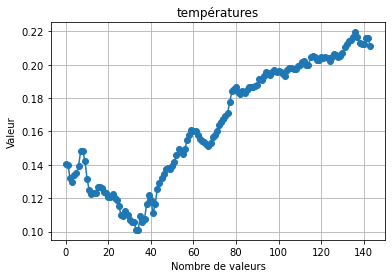

In [73]:
donnees_a_tracer = doc_normalisé['T (degC)'].head(144)

x_values = range(144)

plt.plot(x_values, donnees_a_tracer, marker='o', linestyle='-')
plt.xlabel('Nombre de valeurs')
plt.ylabel('Valeur')
plt.title('températures')
plt.grid(True)

plt.show()

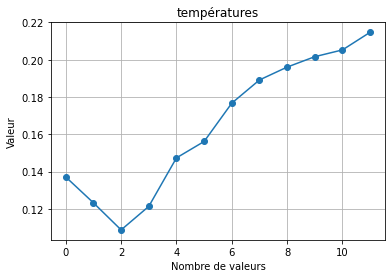

In [74]:
donnees_a_tracer_2 = doc_aggrege['T (degC)'].head(12)

x_values_2 = range(12)

plt.plot(x_values_2, donnees_a_tracer_2, marker='o', linestyle='-')
plt.xlabel('Nombre de valeurs')
plt.ylabel('Valeur')
plt.title('températures')
plt.grid(True)

plt.show()

## 4.Extraction des caractéristiques

In [75]:
def vecteur(df_jour,indice_ligne1,tableau_jour):
    name_col=['p (mbar)','T (degC)','rh (%)','VPact (mbar)','H2OC (mmol/mol)','wv (m/s)']
    vect=[]
    
    tableau_jour.append(df_jour.loc[indice_ligne1,'Date Time'].date())

    for el in name_col:
        for i in range (indice_ligne1,indice_ligne1+12,1):
            vect.append(df_jour.loc[i,el])
        
    return vect

In [76]:
nb_jours=int(doc_aggrege.shape[0]/12)
tableau_jour=[]
matrice_stockee=np.array([vecteur(doc_aggrege.iloc[12*i:12*(i+1)],i*12,tableau_jour) for i in range(nb_jours)])

In [77]:
np.save("matrice_vecteurs",matrice_stockee)

In [78]:
print(matrice_stockee.shape)

(2922, 72)


In [79]:
print(tableau_jour)
print(len(tableau_jour))

[datetime.date(2009, 1, 1), datetime.date(2009, 1, 2), datetime.date(2009, 1, 3), datetime.date(2009, 1, 4), datetime.date(2009, 1, 5), datetime.date(2009, 1, 6), datetime.date(2009, 1, 7), datetime.date(2009, 1, 8), datetime.date(2009, 1, 9), datetime.date(2009, 1, 10), datetime.date(2009, 1, 11), datetime.date(2009, 1, 12), datetime.date(2009, 1, 13), datetime.date(2009, 1, 14), datetime.date(2009, 1, 15), datetime.date(2009, 1, 16), datetime.date(2009, 1, 17), datetime.date(2009, 1, 18), datetime.date(2009, 1, 19), datetime.date(2009, 1, 20), datetime.date(2009, 1, 21), datetime.date(2009, 1, 22), datetime.date(2009, 1, 23), datetime.date(2009, 1, 24), datetime.date(2009, 1, 25), datetime.date(2009, 1, 26), datetime.date(2009, 1, 27), datetime.date(2009, 1, 28), datetime.date(2009, 1, 29), datetime.date(2009, 1, 30), datetime.date(2009, 1, 31), datetime.date(2009, 2, 1), datetime.date(2009, 2, 2), datetime.date(2009, 2, 3), datetime.date(2009, 2, 4), datetime.date(2009, 2, 5), datet

## 5.Recherche par similarité

#### 5.1.Méthode exacte

In [80]:
from sklearn.neighbors import NearestNeighbors

In [101]:
k = 5
distance='euclidian' #ou 'manhattan' ou 'cosine'
plus_proches_voisins = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=distance)


In [102]:
donnees_entrainement = matrice_stockee[:2922-100]
donnees_entrainement = pd.DataFrame(donnees_entrainement)

In [103]:
plus_proches_voisins.fit(donnees_entrainement)

NearestNeighbors(algorithm='brute', metric='jaccard')

In [104]:
requetes = matrice_stockee[-100:]
#requetes = pd.DataFrame(requetes)


c:\Users\33682\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1765: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\Users\33682\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1765: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\Users\33682\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1765: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\Users\33682\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1765: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


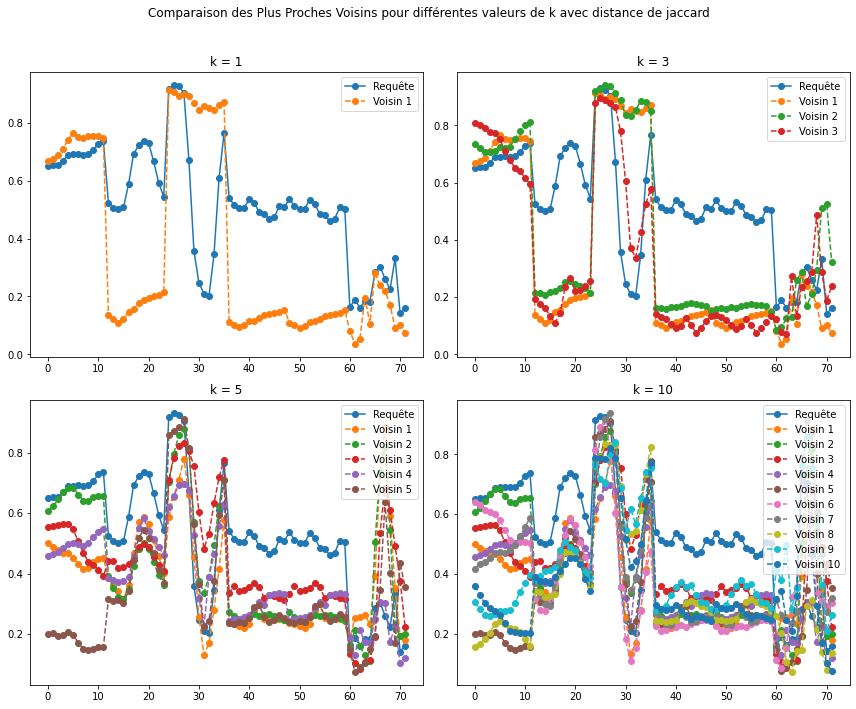

In [105]:
valeurs_de_k = [1, 3, 5, 10]

liste_indices_voisins = []

# Parcourez chaque valeur de k et trouvez les plus proches voisins
for k in valeurs_de_k:
    plus_proches_voisins.n_neighbors = k
    distances, indices = plus_proches_voisins.kneighbors(requetes[0].reshape(1, -1))  
    liste_indices_voisins.append(indices.flatten())

# Visualisation des résultats
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Comparaison des Plus Proches Voisins pour différentes valeurs de k avec distance de jaccard')

for i, ax in enumerate(axes.flatten()):
    k = valeurs_de_k[i]
    indices_voisins = liste_indices_voisins[i]
    
    # Affichage de la requête
    ax.plot(requetes[0], label='Requête', marker='o')
    
    # Affichage des plus proches voisins
    for j, indice in enumerate(indices_voisins):
        ax.plot(donnees_entrainement.iloc[indice], label=f'Voisin {j + 1}', linestyle='dashed', marker='o')

    ax.set_title(f'k = {k}')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()








In [ ]:
nombre_de_requetes = requetes.shape[0]
indices_voisins = []
distances_voisins = []
dates_voisins=[]
for i in range(nombre_de_requetes):
    requete_actuelle = requetes.iloc[i].values.reshape(1, -1)  
    distances, indices = plus_proches_voisins.kneighbors(requete_actuelle, n_neighbors=k)
    indices_voisins.append(indices[0])
    voisins=[]
    for el in indices[0]:
        voisins.append(tableau_jour[el])
    dates_voisins.append(voisins)
    distances_voisins.append(distances)
print(indices_voisins)
print(distances_voisins)
print(dates_voisins)

[array([1004,  233, 1687,  138,  251], dtype=int64), array([1004,  505, 1003,  998, 2441], dtype=int64), array([ 961, 2065,  249,  629,  997], dtype=int64), array([2458, 2094,  644, 2444, 2821], dtype=int64), array([ 264, 2099, 2098, 2100, 1740], dtype=int64), array([1006, 2790,  265, 1340, 1341], dtype=int64), array([1642, 1215, 1300, 1971,  884], dtype=int64), array([2471, 2060,  941, 2108, 2436], dtype=int64), array([2110, 1250,  574, 1717,  901], dtype=int64), array([ 189,  970,  135, 1366,  624], dtype=int64), array([ 299, 1154, 1582, 1925, 1032], dtype=int64), array([2462, 2349, 1961,  108,  253], dtype=int64), array([1165, 1166, 2531, 1795,   74], dtype=int64), array([1582,  130, 1466,  256, 1034], dtype=int64), array([1014, 1925, 2484, 2121, 2123], dtype=int64), array([2484, 1014, 1423, 2481, 1925], dtype=int64), array([1421, 2122, 1015, 2484,  300], dtype=int64), array([2482, 2481, 1052, 2128, 2150], dtype=int64), array([2481, 2480, 2482,  636, 2484], dtype=int64), array([  73

#### 5.2.Méthode approximative

In [ ]:
from lsh import LSH

In [ ]:
#vérité terrain

bf = NearestNeighbors(n_neighbors=1, algorithm='brute')
bf.fit(donnees_entrainement)
ground_results = bf.kneighbors(requetes, n_neighbors=1)
ground_indices=[]
date_voisin_pp=[]
for el in ground_results[1] : 
    indice=el[0]
    ground_indices.append(indice)
    date_voisin_pp.append(tableau_jour[indice])
print(ground_indices)
print(date_voisin_pp)


[1004, 1004, 961, 2458, 264, 1006, 1642, 2471, 2110, 189, 299, 2462, 1165, 1582, 1014, 2484, 1421, 2482, 2481, 73, 1420, 1184, 1920, 2821, 270, 644, 2657, 498, 677, 58, 2491, 58, 1926, 274, 274, 299, 1960, 1465, 2580, 1926, 2636, 1421, 1874, 2514, 35, 1839, 313, 400, 1784, 1849, 1109, 1145, 751, 1103, 343, 2132, 1767, 1010, 1200, 534, 1749, 2481, 1787, 2264, 383, 1118, 1145, 1791, 1112, 2476, 285, 2168, 1797, 1047, 1790, 1791, 2260, 2258, 2126, 1021, 73, 2150, 1448, 51, 1045, 1046, 2579, 2579, 1119, 751, 1109, 1780, 1462, 1803, 322, 1815, 1102, 2173, 54, 751]
[datetime.date(2011, 10, 2), datetime.date(2011, 10, 2), datetime.date(2011, 8, 20), datetime.date(2015, 9, 25), datetime.date(2009, 9, 22), datetime.date(2011, 10, 4), datetime.date(2013, 7, 1), datetime.date(2015, 10, 8), datetime.date(2014, 10, 12), datetime.date(2009, 7, 9), datetime.date(2009, 10, 27), datetime.date(2015, 9, 29), datetime.date(2012, 3, 11), datetime.date(2013, 5, 2), datetime.date(2011, 10, 12), datetime.date

In [ ]:
print(donnees_entrainement.to_numpy())

[[0.66779574 0.67591712 0.68704936 ... 0.09040047 0.1020318  0.07464664]
 [0.73516362 0.71925759 0.70562951 ... 0.51060071 0.52385159 0.32081861]
 [0.80679027 0.80233341 0.79015134 ... 0.28739694 0.18727915 0.2380742 ]
 ...
 [0.56711037 0.55770145 0.55649315 ... 0.12794464 0.09746761 0.06816843]
 [0.5966841  0.59323746 0.5971595  ... 0.09746761 0.12441107 0.16180801]
 [0.63138816 0.63600349 0.63727121 ... 0.1245583  0.24425795 0.16534158]]


In [ ]:
# Infuence du facteur W

w_values = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
precisions = []
inspected_avgs = []
donnees_entrainement_numpy=donnees_entrainement.to_numpy()
requetes_numpy=requetes.to_numpy()

for w in w_values:
    print('Valeur de W:%f' % w)
    lsh = LSH(nb_projections=10, nb_tables=3, w=w)
    lsh.fit(donnees_entrainement_numpy)
    match_count = 0
    inspected_count = 0
    for i, query in enumerate(requetes_numpy):
        lsh_result = lsh.kneighbors(query, k=1)
        lsh_index = lsh_result[1]
        match_count += 1 if lsh_index == ground_indices[i] else 0
        inspected_count += lsh_result[2]

    precision = match_count / len(requetes_numpy)
    precisions.append(precision)
    print('precision: %f' % precision)

    inspected_avg = inspected_count / len(requetes_numpy)
    inspected_avgs.append(inspected_avg)
    print('inspected data: %f' % inspected_avg)

Valeur de W:0.250000


c:\Users\amand\OneDrive\Documents\IMTne\cours CI2\ODATA\code\PROJET\lsh.py:50: RuntimeWarning:

invalid value encountered in cast



precision: 0.850000
inspected data: 1589.920000
Valeur de W:0.500000
precision: 0.940000
inspected data: 1990.350000
Valeur de W:0.750000
precision: 0.980000
inspected data: 2479.960000
Valeur de W:1.000000
precision: 1.000000
inspected data: 2574.400000
Valeur de W:1.250000
precision: 1.000000
inspected data: 2710.410000
Valeur de W:1.500000
precision: 1.000000
inspected data: 2739.410000
Valeur de W:1.750000
precision: 1.000000
inspected data: 2777.760000
Valeur de W:2.000000
precision: 1.000000
inspected data: 2808.380000


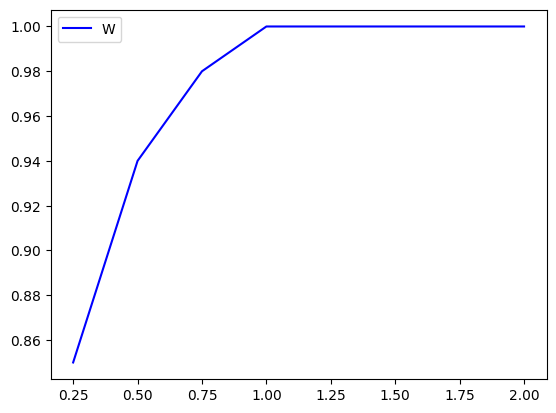

In [ ]:
# courbe de la précision en fonction de W
plt.plot(w_values, precisions, label='W', color='blue')
plt.legend()
plt.show()

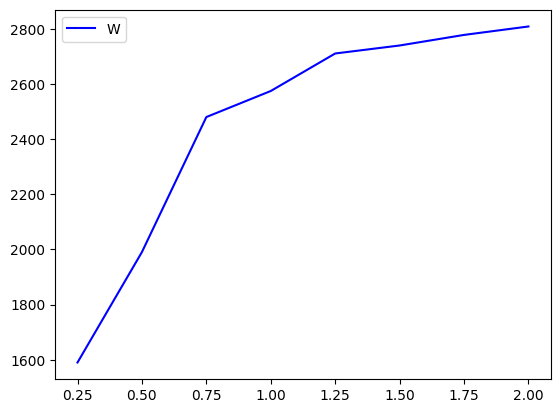

In [ ]:
# courbe du nombre de données inspectés en moyenne en fonction de W
plt.plot(w_values, inspected_avgs, label='W', color='blue')
plt.legend()
plt.show()

In [ ]:
# Infuence du nombre de table de hachage
precisions = []
nb_table= [1,2,3,4,5]

for nt in nb_table:
    print('Nombre de tables:%d' % nt)
    lsh = LSH(nb_projections=10, nb_tables=nt, w=1.0)
    lsh.fit(donnees_entrainement_numpy)
    match_count = 0

    for i, query in enumerate(requetes_numpy):
        lsh_result = lsh.kneighbors(query, k=1)
        lsh_index = lsh_result[1][0]
        match_count += 1 if lsh_index == ground_indices[i] else 0

    precision = match_count / len(requetes_numpy)
    precisions.append(precision)
    print('precision: %f' % precision)

Nombre de tables:1
precision: 0.860000
Nombre de tables:2
precision: 0.960000
Nombre de tables:3
precision: 1.000000
Nombre de tables:4
precision: 1.000000
Nombre de tables:5
precision: 1.000000


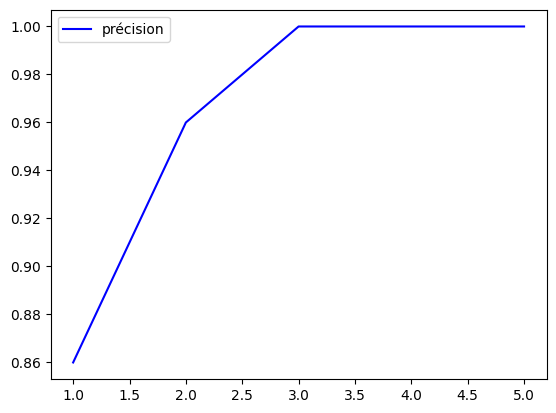

In [ ]:
# courbe de la précision en fonction du nombre de table de hachage
plt.plot(nb_table, precisions, label='précision', color='blue')
plt.legend()
plt.show()

In [ ]:
# Comportement en fonction du nombre de projection

nb_proj=[1,2,3,4,5]
precisions_bis=[]

for nproj in nb_proj:
    print('Nombre de projection:%d' % nproj)
    lsh = LSH(nb_projections=nproj, nb_tables=3, w=1.0)
    lsh.fit(donnees_entrainement_numpy)
    match_count = 0
    

    for i, query in enumerate(requetes_numpy):
        lsh_result = lsh.kneighbors(query, k=1)
        lsh_index = lsh_result[1][0]
        match_count += 1 if lsh_index == ground_indices[i] else 0

    precision_bis = match_count / len(requetes_numpy)
    precisions_bis.append(precision_bis)
    print('precision: %f' % precision_bis)

Nombre de projection:1
precision: 1.000000
Nombre de projection:2
precision: 1.000000
Nombre de projection:3
precision: 1.000000
Nombre de projection:4
precision: 1.000000
Nombre de projection:5
precision: 1.000000


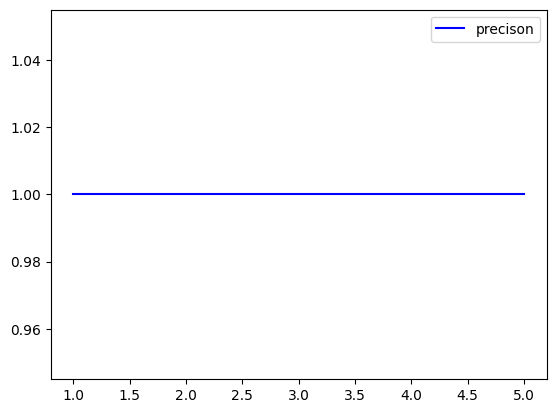

In [ ]:
# courbe de la précision en fonction du nombre de projection
plt.plot(nb_proj, precisions_bis, label='precison', color='blue')
plt.legend()
plt.show()

## 6.Exploitation pratique des résultats de recherche

In [ ]:
w=1.25
t=3
p=3
name_col=['p (mbar)','T (degC)','rh (%)','VPact (mbar)','H2OC (mmol/mol)','wv (m/s)']
val_par_jour=12


In [ ]:
lsh = LSH(nb_projections=p, nb_tables=t, w=w)
lsh.fit(donnees_entrainement_numpy)
query=requetes_numpy[0]
print(query)
print(len(query))
lsh_result = lsh.kneighbors(query, k=2)
lsh_index = lsh_result[1]
lsh_dates = [tableau_jour[el] for el in lsh_index]
print(lsh_dates)

[0.64931463 0.6533159  0.65371207 0.66918232 0.68847556 0.69051581
 0.69208066 0.68992156 0.69273433 0.70590682 0.72761667 0.73649077
 0.52427903 0.50674513 0.50192718 0.50753665 0.58710166 0.69125542
 0.72138482 0.73681946 0.72905912 0.66590956 0.59269392 0.5442219
 0.91604521 0.92999859 0.92483936 0.90361615 0.67255288 0.35834389
 0.24652924 0.20994559 0.20276957 0.34600863 0.60844942 0.76466864
 0.54104478 0.51480501 0.5040122  0.50509549 0.53751404 0.5235516
 0.49017012 0.48391109 0.46589632 0.47287755 0.51360135 0.50826513
 0.53735906 0.5111164  0.50047642 0.50123074 0.5328728  0.51897729
 0.48594569 0.47975226 0.46176751 0.46843735 0.5082182  0.5028188
 0.16372203 0.18830978 0.16195524 0.18389282 0.1819788  0.2844523
 0.30344523 0.2610424  0.22452886 0.33215548 0.14207892 0.16092462]
72
[datetime.date(2011, 10, 2), datetime.date(2009, 8, 22)]


[0.75544727 0.74958403 0.74340385 0.74623643 0.74488947 0.73268758
 0.70146977 0.67619444 0.6657951  0.66991522 0.67371841 0.67286665]


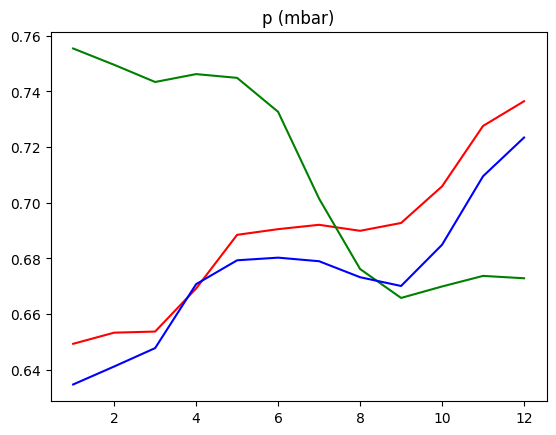

[0.53771767 0.51176956 0.48205314 0.48895313 0.56524881 0.68790006
 0.78529149 0.82178746 0.79423911 0.70600179 0.62456122 0.56899993]


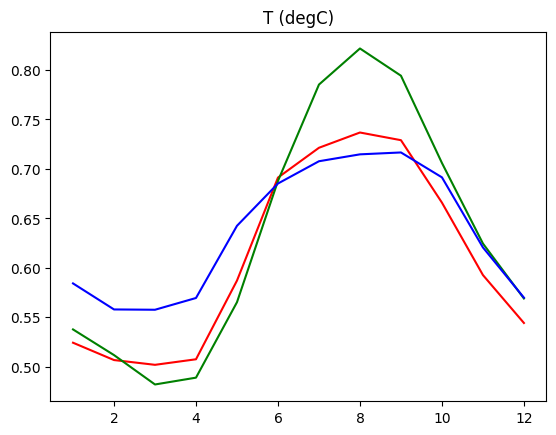

[0.87934431 0.922377   0.95180808 0.90678205 0.70158529 0.47197599
 0.22871817 0.16815581 0.19586323 0.37712818 0.56317715 0.72058065]


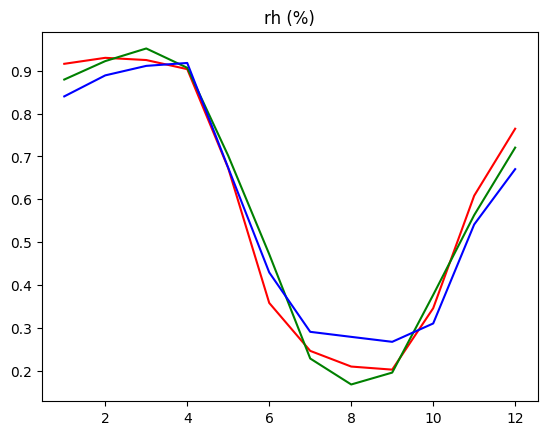

[0.54991173 0.52086342 0.48017975 0.47355962 0.5151661  0.60110737
 0.5814476  0.5863826  0.56608089 0.55970149 0.54517734 0.53105441]


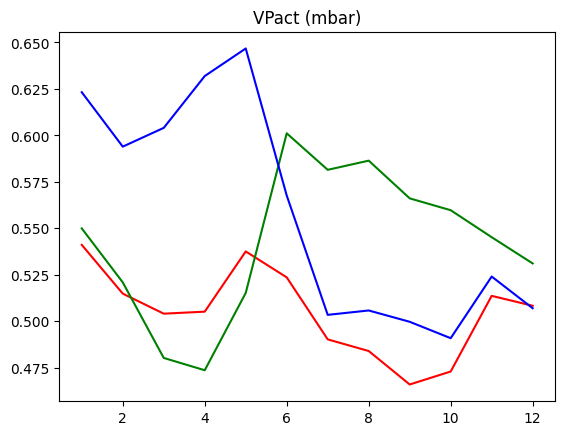

[0.54355249 0.51492774 0.47490869 0.46819914 0.50952835 0.59472765
 0.57618707 0.58166587 0.56181515 0.55534381 0.54081309 0.52683818]


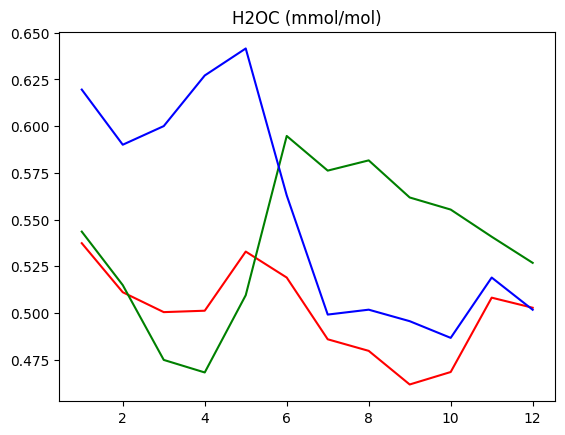

[0.09525913 0.11410483 0.12514723 0.11057126 0.17550059 0.13722026
 0.19802709 0.19596584 0.28386337 0.151649   0.18035925 0.10792108]


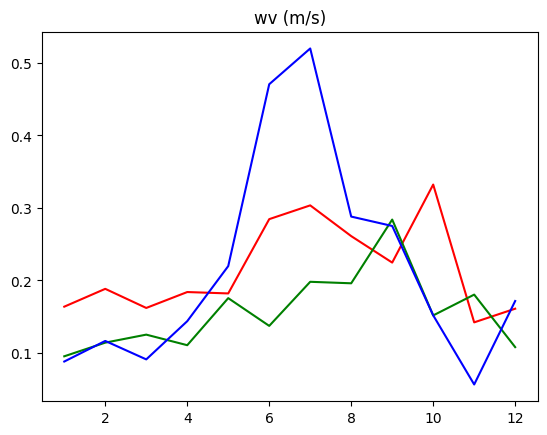

In [ ]:
ind_vect=0

for el in name_col : 

    # Données pour les trois courbes
    x_values = [1,2,3,4,5,6,7,8,9,10,11,12]
    y1_values = query[ind_vect:ind_vect+12]
    y2_vect = donnees_entrainement_numpy[lsh_index[0]]
    y2_values =y2_vect[ind_vect:ind_vect+12]
    print(y2_values)
    y3_vect = donnees_entrainement_numpy[lsh_index[1]]
    y3_values =y3_vect[ind_vect:ind_vect+12]


    plt.plot(x_values, y1_values, label='jour', color='red')
    plt.plot(x_values, y2_values, label='voisin 1', color='green')
    plt.plot(x_values, y3_values, label='voisin 2', color='blue')

    plt.title(el)
    plt.show()

    ind_vect+=12


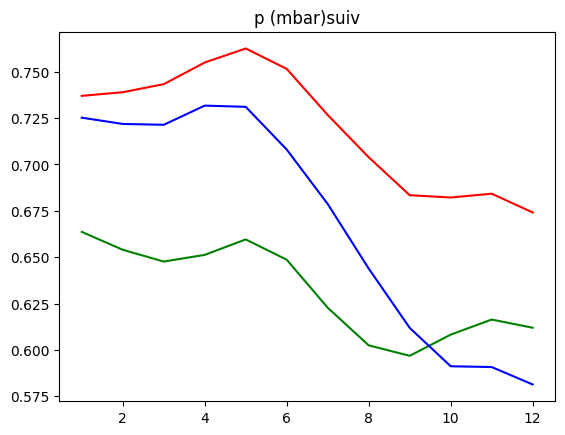

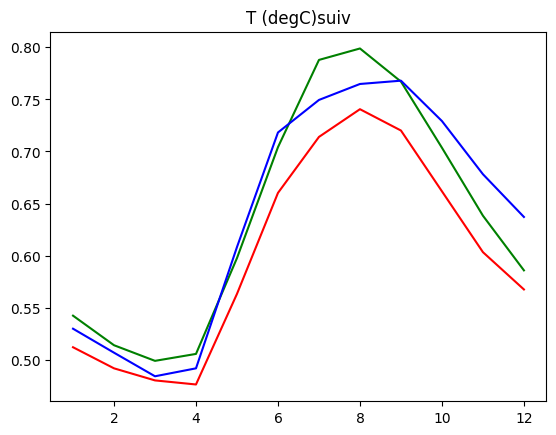

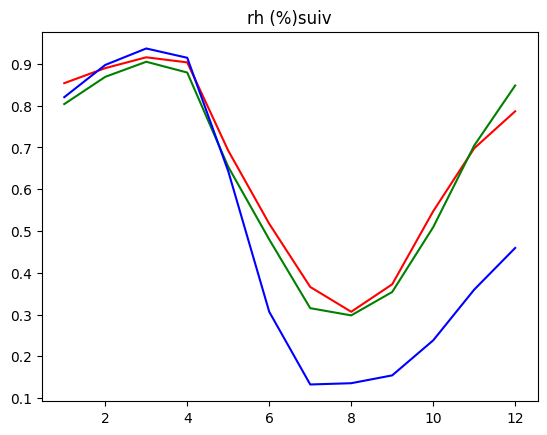

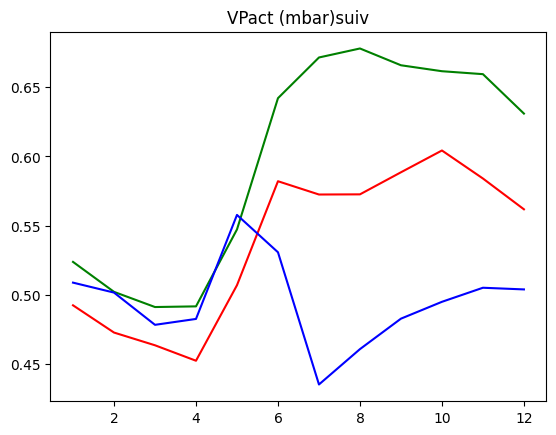

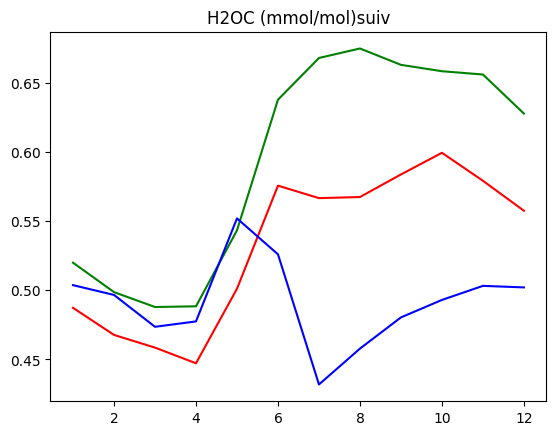

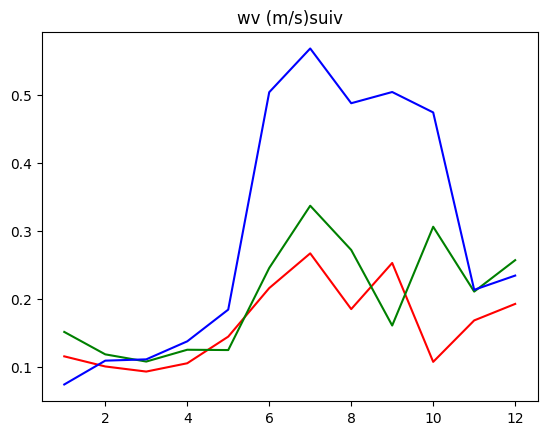

In [ ]:
ind_vect=0
query_suiv=requetes_numpy[1]

for el in name_col : 

    # Données pour les trois courbes
    x_values = [1,2,3,4,5,6,7,8,9,10,11,12]
    y1_values_suiv = query_suiv[ind_vect:ind_vect+12]
    y2_vect_suiv = donnees_entrainement_numpy[lsh_index[0]+1]
    y2_values_suiv =y2_vect_suiv[ind_vect:ind_vect+12]
    y3_vect_suiv = donnees_entrainement_numpy[lsh_index[1]+1]
    y3_values_suiv =y3_vect_suiv[ind_vect:ind_vect+12]


    plt.plot(x_values, y1_values_suiv, label='jour', color='red')
    plt.plot(x_values, y2_values_suiv, label='voisin 1', color='green')
    plt.plot(x_values, y3_values_suiv, label='voisin 2', color='blue')

    plt.title(el+'suiv')
    plt.show()

    ind_vect+=12
